In [1]:
import torch
import numpy as np
from transformers import BertTokenizer#, XLNetModel
import pandas as pd
from torch import nn
from transformers import BertModel
from torch.optim import Adam, AdamW
from tqdm import tqdm, notebook
import nlpaug.augmenter.word.context_word_embs as nwa
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

labels = {'no-clickbait': 0, 'clickbait' : 1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['truthClass']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['postText']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y
    
    
    
    
    
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

    
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in notebook.tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')


Primero de todo vamos a hacer una pequeña visualización de los datos para familiarizarnos con ellos:

In [19]:
train_df = pd.read_csv('webis_train.csv')
test_df = pd.read_csv('webis_test.csv')

train_df.head()

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0,0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000
1,1,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000
2,2,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333
3,3,[],Meet the happiest #dog in the world!,858323428260139008,"['Maru ', 'Maru', 'Maru', 'Maru', 'Maru']",['Adorable is probably an understatement. This...,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...","[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.000000,1.000000
4,4,[],Tokyo's subway is shut down amid fears over an...,858283602626347008,"[""All nine lines of Tokyo's subway system were...","[""One of Tokyo's major subways systems says it...",Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000


Vamos a hacer un primer modelo, para poder evaluar su rendimiento y poder utilizarlo como baseline

In [3]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

train_df = pd.read_csv('webis_train.csv')
test_df = pd.read_csv('webis_test.csv')
train_df['postText'] = train_df['postText'].astype(str).fillna("DUMMY_VALUE")
test_df['postText'] = test_df['postText'].astype(str).fillna("DUMMY_VALUE")

train(model, train_df, test_df, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/9769 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.199                 | Train Accuracy:  0.829                 | Val Loss:  0.164                 | Val Accuracy:  0.860


  0%|          | 0/9769 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  0.157                 | Train Accuracy:  0.869                 | Val Loss:  0.158                 | Val Accuracy:  0.862


  0%|          | 0/9769 [00:00<?, ?it/s]

Epochs: 3 | Train Loss:  0.124                 | Train Accuracy:  0.903                 | Val Loss:  0.169                 | Val Accuracy:  0.855


  0%|          | 0/9769 [00:00<?, ?it/s]

Epochs: 4 | Train Loss:  0.081                 | Train Accuracy:  0.944                 | Val Loss:  0.201                 | Val Accuracy:  0.849


  0%|          | 0/9769 [00:00<?, ?it/s]

Epochs: 5 | Train Loss:  0.050                 | Train Accuracy:  0.972                 | Val Loss:  0.232                 | Val Accuracy:  0.849


  0%|          | 0/9490 [00:00<?, ?it/s]

              precision    recall  f1-score   support

no-clickbait       0.90      0.91      0.90     14464
   clickbait       0.69      0.67      0.68      4515

    accuracy                           0.85     18979
   macro avg       0.79      0.79      0.79     18979
weighted avg       0.85      0.85      0.85     18979



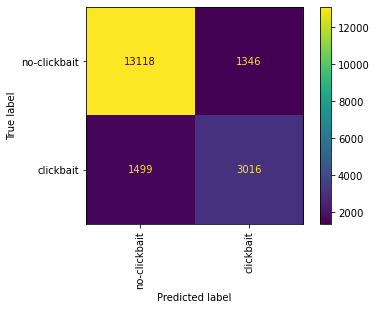

In [4]:
for param in model.parameters():
    param.requires_grad = False
model.eval();

test_dataloader = torch.utils.data.DataLoader(Dataset(test_df), batch_size=2)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

real_values, predicted_values = [], []
cont = 0
for test_input, test_label in notebook.tqdm(test_dataloader):
    cont += 1
    
    test_label = test_label.to(device)
    mask = test_input['attention_mask'].to(device)
    input_id = test_input['input_ids'].squeeze(1).to(device)
    pred = model(input_id, mask)
    
    for i in range(len(test_label.cpu().numpy())):
        real_values.append(test_label.cpu().numpy()[i])
        predicted_values.append(pred.argmax(dim=1).cpu().numpy()[i])
    
    
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(real_values, predicted_values)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no-clickbait', 'clickbait'])
disp.plot(xticks_rotation='vertical')


print(classification_report(real_values, predicted_values, target_names=['no-clickbait', 'clickbait']))

Vemos que clasifica mucho mejor la clase 'no-clickbait' que la clase 'clickbait'. Esto se debe a que los datos estan desbalanceados. Vamos a hacer Data augmentation para poder balancear los datos utilizando la libreria nlpaug.

In [5]:
aug = nwa.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

Veamos como funciona

In [6]:
text = 'The quick brown fox jumps over the lazy dog'
print(aug.augment(text))
print(aug.augment(text))

the quick buck brown fox quickly jumps over the lazy big dog
the quick brown silver fox once jumps over the young lazy dog


Vamos a aplicarlo a nuestra base de datos y a entrenar un modelo con estos nuevos datos balanceados. Guardaremos el dataset resultante para no tener que volver a hacer el proceso de Data augmentation y ahorrarnos tiempo en el futuro.

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

labels = {'no-clickbait': 0, 'clickbait' : 1}


EPOCHS = 5
model = BertClassifier()
LR = 1e-6

train_df = pd.read_csv('webis_train.csv')
test_df = pd.read_csv('webis_test.csv')
train_df['postText'] = train_df['postText'].astype(str).fillna("DUMMY_VALUE")
test_df['postText'] = test_df['postText'].astype(str).fillna("DUMMY_VALUE")

aug = nwa.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
it = train_df.shape[0]
print("Data augmentation...")
for i in notebook.tqdm(range(it)):
    if train_df['truthClass'][i] == 'clickbait':
        for _ in range(2):
            aux = train_df.iloc[i]
            text = aux['postText']
            #print(text)
            newtext = aug.augment(text)
            aux['postText'] = newtext
            train_df = train_df.append(aux, ignore_index=True)

train_df.to_csv('train_data_augmentation.csv')


print("Starting training...")
train(model, train_df, test_df, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Data augmentation...


  0%|          | 0/19538 [00:00<?, ?it/s]

/home/david/anaconda3/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


Starting training...


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.160                 | Train Accuracy:  0.866                 | Val Loss:  0.163                 | Val Accuracy:  0.858


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  0.103                 | Train Accuracy:  0.918                 | Val Loss:  0.168                 | Val Accuracy:  0.852


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 3 | Train Loss:  0.068                 | Train Accuracy:  0.952                 | Val Loss:  0.189                 | Val Accuracy:  0.850


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 4 | Train Loss:  0.036                 | Train Accuracy:  0.979                 | Val Loss:  0.237                 | Val Accuracy:  0.841


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 5 | Train Loss:  0.021                 | Train Accuracy:  0.990                 | Val Loss:  0.279                 | Val Accuracy:  0.849


  0%|          | 0/9490 [00:00<?, ?it/s]

              precision    recall  f1-score   support

no-clickbait       0.91      0.89      0.90     14464
   clickbait       0.66      0.73      0.70      4515

    accuracy                           0.85     18979
   macro avg       0.79      0.81      0.80     18979
weighted avg       0.85      0.85      0.85     18979



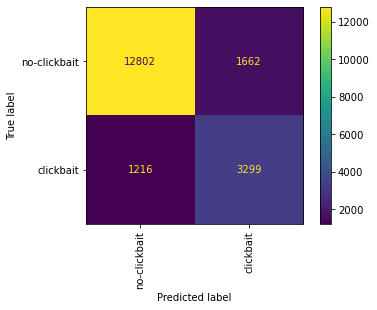

In [8]:
for param in model.parameters():
    param.requires_grad = False
model.eval();

test_dataloader = torch.utils.data.DataLoader(Dataset(test_df), batch_size=2)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

real_values, predicted_values = [], []
cont = 0
for test_input, test_label in notebook.tqdm(test_dataloader):
    cont += 1
    
    test_label = test_label.to(device)
    mask = test_input['attention_mask'].to(device)
    input_id = test_input['input_ids'].squeeze(1).to(device)
    pred = model(input_id, mask)
    
    for i in range(len(test_label.cpu().numpy())):
        real_values.append(test_label.cpu().numpy()[i])
        predicted_values.append(pred.argmax(dim=1).cpu().numpy()[i])
    
    
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(real_values, predicted_values)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no-clickbait', 'clickbait'])
disp.plot(xticks_rotation='vertical')

print(classification_report(real_values, predicted_values, target_names=['no-clickbait', 'clickbait']))

Vemos que al hacer data augmentation vemos que por un lado hemos disminuido un poco la accuracy. Por otra parte, hemos conseguido aumentar la precisión en el momento que predecimos clickbait. Dado que el objetivo es predecir clickbait, se puede considerar que es preferible tener una accuracy un poco mas baja a cambio de tener una precisión el la predicción de clickbaits mas alta.

Vemos que la Train Accuracy mejora en cada época de manera considerable, pero la Validation Accuracy se estanca. Estamos sufriendo un problema de overfitting. Vamos a mejorar eso aumentando el parámetro de regularización de nuestro optimizador. Además en los dos modelos anteriores a partir de la tercera época de entrenamiento la validation loss volvia a aumentar. Para reducir el overfitting, vamos a detener el entrenamiento después de la segunda época:

In [9]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate, weight_decay = 0.1)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
    

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in notebook.tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [10]:
train_df = pd.read_csv('train_data_augmentation.csv')
test_df = pd.read_csv('webis_test.csv')
test_df['postText'] = test_df['postText'].astype(str).fillna("DUMMY_VALUE")
train_df['postText'] = train_df['postText'].astype(str).fillna("DUMMY_VALUE")

EPOCHS = 2
model = BertClassifier()
LR = 1e-6

print("Starting training...")
train(model, train_df, test_df, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting training...


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.183                 | Train Accuracy:  0.853                 | Val Loss:  0.188                 | Val Accuracy:  0.843


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  0.146                 | Train Accuracy:  0.883                 | Val Loss:  0.187                 | Val Accuracy:  0.841


  0%|          | 0/9490 [00:00<?, ?it/s]

              precision    recall  f1-score   support

no-clickbait       0.89      0.91      0.90     14464
   clickbait       0.69      0.64      0.66      4515

    accuracy                           0.85     18979
   macro avg       0.79      0.77      0.78     18979
weighted avg       0.84      0.85      0.84     18979



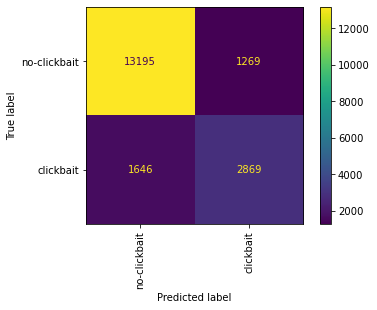

In [11]:
for param in model.parameters():
    param.requires_grad = False
model.eval();

test_dataloader = torch.utils.data.DataLoader(Dataset(test_df), batch_size=2)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

real_values, predicted_values = [], []
cont = 0
for test_input, test_label in notebook.tqdm(test_dataloader):
    cont += 1
    
    test_label = test_label.to(device)
    mask = test_input['attention_mask'].to(device)
    input_id = test_input['input_ids'].squeeze(1).to(device)
    pred = model(input_id, mask)
    
    for i in range(len(test_label.cpu().numpy())):
        real_values.append(test_label.cpu().numpy()[i])
        predicted_values.append(pred.argmax(dim=1).cpu().numpy()[i])
    
    
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(real_values, predicted_values)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no-clickbait', 'clickbait'])
disp.plot(xticks_rotation='vertical')

print(classification_report(real_values, predicted_values, target_names=['no-clickbait', 'clickbait']))

Vemos que al cambiar el parámetro de regularización ha disminuido la train_accuracy, pero la val_accuracy se ha mantenido. Si nos fijamos en la matriz de confusión hemos perdido precisión en la clasificación de la clase 'no-clickbait', pero hemos ganado una poca en las predicciones de la clase 'clickbait'. Aún así no es suficiente. Vamos a cambiar el optimizador.

In [12]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr= learning_rate, weight_decay = 0.1)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
    

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in notebook.tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [13]:
train_df = pd.read_csv('train_data_augmentation.csv')
test_df = pd.read_csv('webis_test.csv')
test_df['postText'] = test_df['postText'].astype(str).fillna("DUMMY_VALUE")
train_df['postText'] = train_df['postText'].astype(str).fillna("DUMMY_VALUE")

EPOCHS = 2
model = BertClassifier()
LR = 1e-6

print("Starting training...")
train(model, train_df, test_df, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting training...


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.155                 | Train Accuracy:  0.871                 | Val Loss:  0.166                 | Val Accuracy:  0.855


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  0.104                 | Train Accuracy:  0.916                 | Val Loss:  0.164                 | Val Accuracy:  0.857


  0%|          | 0/9490 [00:00<?, ?it/s]

              precision    recall  f1-score   support

no-clickbait       0.90      0.92      0.91     14464
   clickbait       0.72      0.69      0.70      4515

    accuracy                           0.86     18979
   macro avg       0.81      0.80      0.81     18979
weighted avg       0.86      0.86      0.86     18979



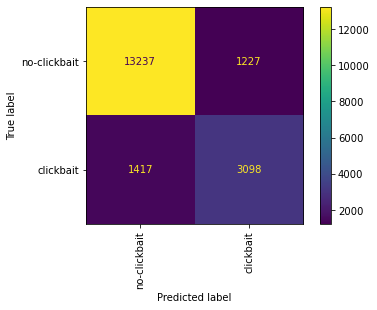

In [14]:
for param in model.parameters():
    param.requires_grad = False
model.eval();

test_dataloader = torch.utils.data.DataLoader(Dataset(test_df), batch_size=2)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

real_values, predicted_values = [], []
cont = 0
for test_input, test_label in notebook.tqdm(test_dataloader):
    cont += 1
    
    test_label = test_label.to(device)
    mask = test_input['attention_mask'].to(device)
    input_id = test_input['input_ids'].squeeze(1).to(device)
    pred = model(input_id, mask)
    
    for i in range(len(test_label.cpu().numpy())):
        real_values.append(test_label.cpu().numpy()[i])
        predicted_values.append(pred.argmax(dim=1).cpu().numpy()[i])
    
    
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(real_values, predicted_values)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no-clickbait', 'clickbait'])
disp.plot(xticks_rotation='vertical')

print(classification_report(real_values, predicted_values, target_names=['no-clickbait', 'clickbait']))

Hasta ahora, la mayor accuracy la hemos obtenido con el modelo simple, sin data augmentation. Aún así, és preferible utilizar el modelo entrenado con el dataset aumentado, ya que como hemos podido clasificar mejor las muestras que son clickbait. Después hemos visto que aumentar el parámetro weight_decay no ha tenido muy buenos resultados.
Al cambiar el optimizador a AdamW con weight_decay=0.1 hemos disminuido la loss. Vamos a probar un modelo con el optimizador AdamW pero con el weight_decay=0.01

In [15]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
    

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in notebook.tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [16]:
train_df = pd.read_csv('train_data_augmentation.csv')
test_df = pd.read_csv('webis_test.csv')
test_df['postText'] = test_df['postText'].astype(str).fillna("DUMMY_VALUE")
train_df['postText'] = train_df['postText'].astype(str).fillna("DUMMY_VALUE")

EPOCHS = 2
model = BertClassifier()
LR = 1e-6

print("Starting training...")
train(model, train_df, test_df, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting training...


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.155                 | Train Accuracy:  0.868                 | Val Loss:  0.163                 | Val Accuracy:  0.859


  0%|          | 0/14530 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  0.104                 | Train Accuracy:  0.915                 | Val Loss:  0.159                 | Val Accuracy:  0.860


  0%|          | 0/9490 [00:00<?, ?it/s]

              precision    recall  f1-score   support

no-clickbait       0.89      0.94      0.91     14464
   clickbait       0.75      0.63      0.69      4515

    accuracy                           0.86     18979
   macro avg       0.82      0.78      0.80     18979
weighted avg       0.86      0.86      0.86     18979



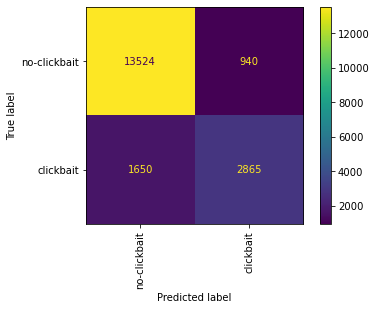

In [17]:
for param in model.parameters():
    param.requires_grad = False
model.eval();

test_dataloader = torch.utils.data.DataLoader(Dataset(test_df), batch_size=2)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

real_values, predicted_values = [], []
cont = 0
for test_input, test_label in notebook.tqdm(test_dataloader):
    cont += 1
    
    test_label = test_label.to(device)
    mask = test_input['attention_mask'].to(device)
    input_id = test_input['input_ids'].squeeze(1).to(device)
    pred = model(input_id, mask)
    
    for i in range(len(test_label.cpu().numpy())):
        real_values.append(test_label.cpu().numpy()[i])
        predicted_values.append(pred.argmax(dim=1).cpu().numpy()[i])
    
    
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(real_values, predicted_values)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no-clickbait', 'clickbait'])
disp.plot(xticks_rotation='vertical')

print(classification_report(real_values, predicted_values, target_names=['no-clickbait', 'clickbait']))

Después de haber evaluado todos estos modelos, podemos concluir que el mejor modelo es el que hemos utilizado utilizando data augmentation, utilizando la función de Cross Entropy como loss y un optimizador Adam.